In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import yaml
import os
import glob
import re
from matplotlib import pyplot as plt

os.chdir('/home/jp4474/latent-abc-smc')

from models import TiMAE
from lightning_module import PreTrainLightning, FineTuneLightning
from systems import MZB
from dataset import NumpyDataset

In [2]:
folder_name = "/home/jp4474/latent-abc-smc/mzb_d128_ed128_12_8_ae_mask_0.15_beta_2"
config = yaml.safe_load(open(f"{folder_name}/config.yaml"))
model = TiMAE(**config["model"]["params"])
# get all the files that end with .ckpt and get the last one
checkpoint_path = [os.path.join(folder_name, f) for f in os.listdir(folder_name) if f.endswith(".ckpt")]
checkpoint_path = checkpoint_path[0]
print(checkpoint_path)
pl_model = PreTrainLightning.load_from_checkpoint(checkpoint_path, model = model)
pl_model.eval()
# print("Successfully loaded model")

FileNotFoundError: [Errno 2] No such file or directory: '/home/jp4474/latent-abc-smc/mzb_d128_ed128_12_8_ae_mask_0.15_beta_2/config.yaml'

In [ ]:
# raw_data = np.load("data/mzb_data.npy")
# # find the row with nan values from numpy array
# nan_loc = np.isnan(raw_data) #.any(axis=1)
# # 0 out the nan values
# raw_data[nan_loc] = 0
# scale = np.abs(raw_data).mean(axis=0)
# scaled_raw_data = np.arcsinh(raw_data)/10 # / scale
scaled_raw_data = np.load("/home/jp4474/latent-abc-smc/data/mzb_data_scaled.npy")
mzb_abc = MZB(tmax=732, observational_data=scaled_raw_data)
mzb_abc.update_model(pl_model)

INFO:latent_abc_smc:Initializing LatentABCSMC class
INFO:latent_abc_smc:Initialization complete
INFO:latent_abc_smc:LatentABCSMC class initialized with the following parameters:
INFO:latent_abc_smc:num_particles: 1000
INFO:latent_abc_smc:num_generations: 5
INFO:latent_abc_smc:num_parameters: 6
INFO:latent_abc_smc:lower_bounds: [ 0.5 14.   0.1 -5.   3.5 -4. ]
INFO:latent_abc_smc:upper_bounds: [0.25 2.   0.15 1.2  0.8  1.2 ]
INFO:latent_abc_smc:tolerance_levels: [30 20 10  5  1]
INFO:latent_abc_smc:perturbation_kernels: [0.1 0.1 0.1 0.1 0.1 0.1]
INFO:latent_abc_smc:t0: 40
INFO:latent_abc_smc:tmax: 732
INFO:latent_abc_smc:time_space: [ 59  69  76  88  95 102 108 109 113 119 122 123 124 141 156 158 183 212
 217 219 235 261 270 289 291 306 442 524 563 566 731]
INFO:latent_abc_smc:Model updated


In [ ]:
train_dataset = NumpyDataset("data", "train")
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=768, shuffle=True)

In [ ]:
latent_representations = []
params = []
for batch in train_dataloader:
    x, y = batch
    y = y.to(pl_model.device).float()
    with torch.no_grad():
        z = pl_model.get_latent(y).cpu()
        latent_representations.append(z)
    params.append(x)

latent_representations = torch.cat(latent_representations, dim=0)
params = torch.cat(params, dim=0)

In [ ]:
df = pd.DataFrame(latent_representations.numpy())
# append two columns
df["a"] = params[:, 0].numpy()
df["b"] = params[:, 1].numpy()
df["c"] = params[:, 2].numpy()
df["d"] = params[:, 3].numpy()
df["e"] = params[:, 4].numpy()
df["f"] = params[:, 5].numpy()

In [ ]:
def calculate_similarity(a, b):
    a = a #.flatten()
    b = b.flatten()
    
    norm_x = np.linalg.norm(a)
    norm_y = np.linalg.norm(b)
        
    cosine_similarity = np.dot(a, b) / (norm_x * norm_y)
    # Clip to handle numerical errors
    return cosine_similarity

mzb_abc.encode_observational_data()

df['similarity'] = df.apply(
    lambda row: calculate_similarity(
        row[:-6], 
        mzb_abc.encoded_observational_data
    ), 
    axis=1
)

In [ ]:
df = df.sort_values(by='similarity', ascending=False)

In [ ]:
df.head(1000).mean()

0            -0.186034
1            -0.224245
2            -0.125395
3             0.138568
4            -0.424681
                ...   
c             0.504392
d             0.334969
e             0.503953
f             0.194969
similarity    0.851154
Length: 263, dtype: float64

In [ ]:
df.head(50).mean()[-7:].to_numpy()[:-1]

array([0.13141118, 0.8083282 , 0.53811233, 0.39590058, 0.49626981,
       0.12847851])

In [ ]:
with torch.no_grad():
    _, _, _, param_est, raw = pl_model(torch.tensor(mzb_abc.raw_observational_data).unsqueeze(0).to('cuda').float())

In [ ]:
max_ = np.array([ 0.99998673, 19.99958512,  0.5999854 , -1.00000201,  6.49953051,
         0.49987116])
min_ = np.array([ 6.16673630e-06,  8.00015844e+00,  1.35937240e-05, -8.99987713e+00,
    1.00007737e+00, -5.99925511e+00])

In [ ]:
param_est_org = param_est.squeeze(0).cpu().numpy() * (max_ - min_) + min_
print(param_est_org)

[ 0.19993086 17.43994017  0.27841897 -5.46168835  3.29168526 -4.60645609]


In [ ]:
param_est_org

array([ 0.19993086, 17.43994017,  0.27841897, -5.46168835,  3.29168526,
       -4.60645609])

In [ ]:
raw_np = raw.squeeze(0).cpu().numpy()

In [ ]:
# simulated_np, status = mzb_abc.simulate(df.head(50).mean()[-7:].to_numpy()[:-1])
simulated_np, status = mzb_abc.simulate(param_est_org)
simulated_np_scale = np.mean(np.abs(simulated_np), axis=0)
simulated_np_scaled = simulated_np / simulated_np_scale
raw_np_scaled = raw_np # * scale

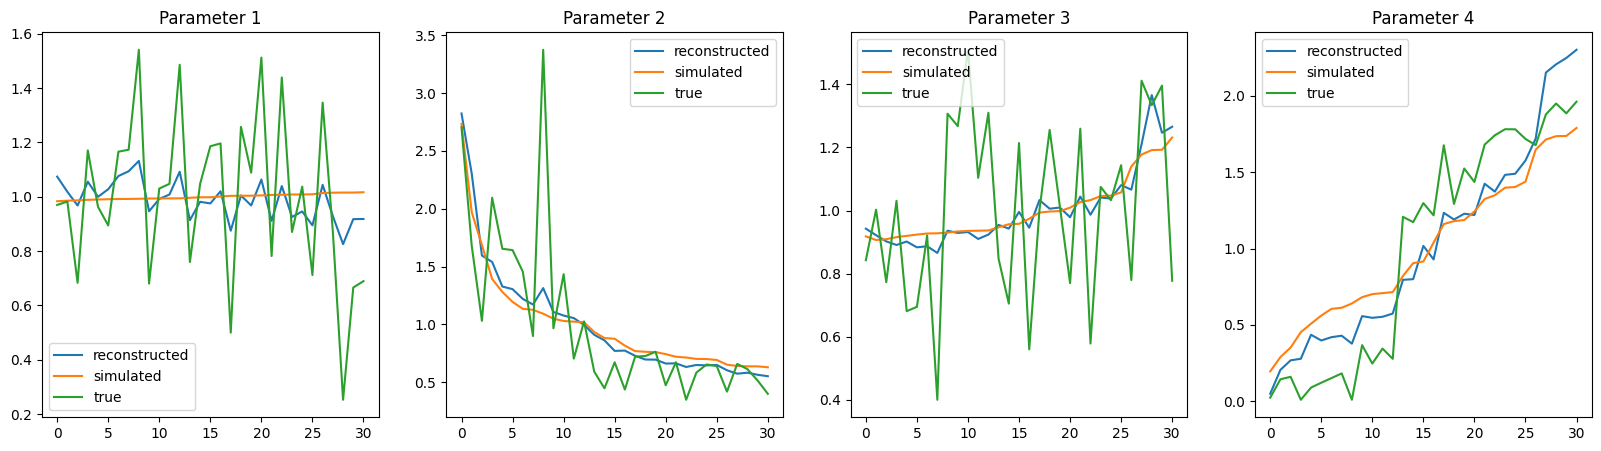

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4):
    ax[i].plot(raw_np_scaled[:, i], label='reconstructed')
    ax[i].plot(simulated_np_scaled[:, i], label='simulated')
    ax[i].plot(scaled_raw_data[:, i], label='true')
    ax[i].legend()
    ax[i].set_title(f"Parameter {i+1}")

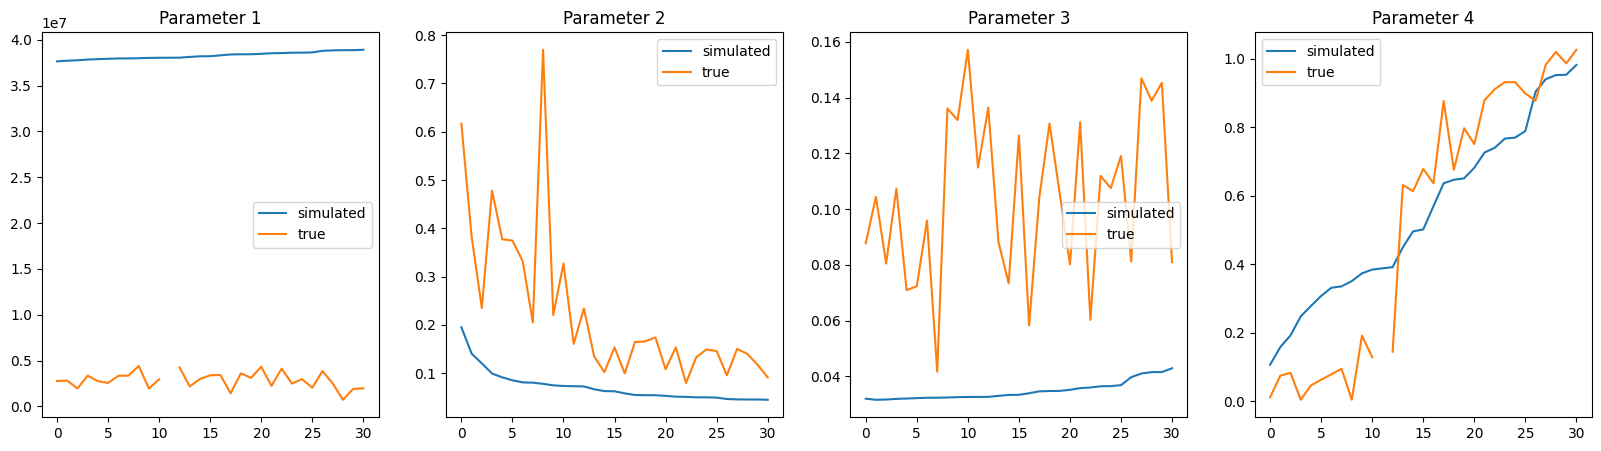

In [ ]:
raw_data = np.load("/home/jp4474/latent-abc-smc/data/mzb_data.npy")
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4):
    #ax[i].plot(raw_np[:, i], label='reconstructed')
    ax[i].plot(simulated_np[:, i], label='simulated')
    ax[i].plot(raw_data[:, i], label='true')
    ax[i].legend()
    ax[i].set_title(f"Parameter {i+1}")

In [ ]:
mzb_abc = MZB(tmax=732, 
              observational_data=scaled_raw_data,
              num_particles=1000,
              tolerance_levels=[0.2, 0.1, 0.05, 0.01, 0.005])
mzb_abc.update_model(pl_model)
mzb_abc.run()


INFO:latent_abc_smc:Initializing LatentABCSMC class
INFO:latent_abc_smc:Initialization complete
INFO:latent_abc_smc:LatentABCSMC class initialized with the following parameters:
INFO:latent_abc_smc:num_particles: 1000
INFO:latent_abc_smc:num_generations: 5
INFO:latent_abc_smc:num_parameters: 6
INFO:latent_abc_smc:lower_bounds: [ 0.5 14.   0.1 -5.   3.5 -4. ]
INFO:latent_abc_smc:upper_bounds: [0.25 2.   0.15 1.2  0.8  1.2 ]
INFO:latent_abc_smc:tolerance_levels: [0.2, 0.1, 0.05, 0.01, 0.005]
INFO:latent_abc_smc:perturbation_kernels: [0.1 0.1 0.1 0.1 0.1 0.1]
INFO:latent_abc_smc:t0: 40
INFO:latent_abc_smc:tmax: 732
INFO:latent_abc_smc:time_space: [ 59  69  76  88  95 102 108 109 113 119 122 123 124 141 156 158 183 212
 217 219 235 261 270 289 291 306 442 524 563 566 731]
INFO:latent_abc_smc:Model updated
INFO:latent_abc_smc:Starting ABC SMC run
INFO:latent_abc_smc:Generation 1 started


KeyboardInterrupt: 

In [ ]:
# array([ 0.29344263, 17.75133056,  0.30939664, -6.43075927,  3.68567227, -4.84717171])
# [ 0.21184074 16.47225595  0.20836052 -6.2382867   3.42637951 -4.5757404 ]